<a href="https://colab.research.google.com/github/ksetdekov/test_predict_ts/blob/main/analysis_and_fx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import json

import numpy as np
import pandas as pd
import seaborn as sns

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.serialize import model_to_json, model_from_json



In [3]:
%matplotlib inline

In [4]:
data_url = 'https://raw.githubusercontent.com/ksetdekov/test_predict_ts/main/2_5350833418869411277.csv'
data = pd.read_csv(data_url)
data

,date,clients
0,1/2/2010 0:00,129.0
1,1/2/2010 1:00,148.0
2,1/2/2010 2:00,159.0
3,1/2/2010 3:00,181.0
4,1/2/2010 4:00,138.0
...,...,...
43795,NaN,NaN
43796,NaN,NaN
43797,NaN,NaN
43798,NaN,NaN


In [ ]:
data.tail(30)

,date,clients
43770,12/30/2014 18:00,79.0
43771,12/30/2014 19:00,35.0
43772,12/30/2014 20:00,26.0
43773,12/30/2014 21:00,20.0
43774,12/30/2014 22:00,8.0
43775,12/30/2014 23:00,16.0
43776,NaN,NaN
43777,NaN,NaN
43778,NaN,NaN
43779,NaN,NaN


In [ ]:
data.date = pd.to_datetime(data.date)

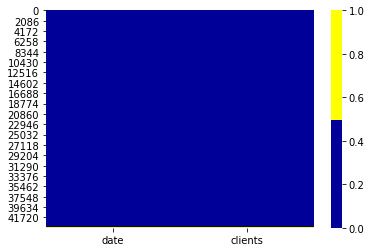

In [ ]:
colors = ['#000099', '#ffff00'] 

a = sns.heatmap(data.isnull(), cmap=sns.color_palette(colors))

Визуально пропусков не подавляющее число

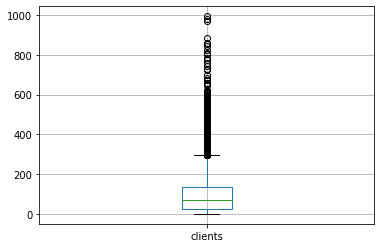

In [ ]:
data.boxplot(column=['clients'])

In [ ]:
data.describe()

,clients
count,43776.000000
mean,94.059553
std,92.256575
min,0.000000
25%,24.000000
50%,68.000000
75%,133.000000
max,994.000000


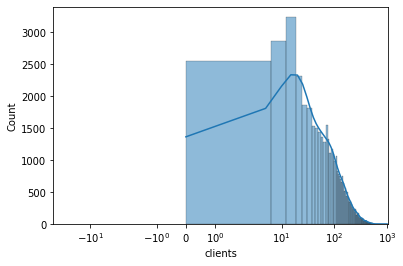

In [ ]:
ax = sns.histplot(data=data, x="clients", kde=True)
ax.set_xscale('symlog')

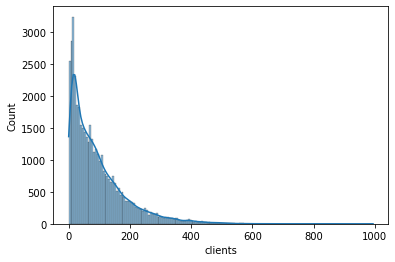

In [ ]:
sns.histplot(data=data, x="clients", kde=True)

Целевая переменная с тяжелым правым хвостом, наблюдаемые значение имеют положительную ассиметрию, мода меньше среднего, все наблюдаемые значения $< 1000$.

In [ ]:
misscount = data.isna().sum()
misscount[misscount>0]

date       24
clients    24
dtype: int64

Есть предположение, что 0 могуть быть пропусками, других пропусков, кроме хвоста датасета нет.

# FB prophet

In [ ]:
df=data.copy()
df.dropna(inplace=True)
df.columns =['ds', 'y']
df['cap'] = 2000
df['floor'] = 0
df.head()

,ds,y,cap,floor
0,2010-01-02 00:00:00,129.0,2000,0
1,2010-01-02 01:00:00,148.0,2000,0
2,2010-01-02 02:00:00,159.0,2000,0
3,2010-01-02 03:00:00,181.0,2000,0
4,2010-01-02 04:00:00,138.0,2000,0


In [ ]:
m = Prophet(growth = 'logistic',  daily_seasonality=True)
# m = Prophet(mcmc_samples=300)

m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=48, freq='H')
future['cap'] = 2000
future['floor'] = 0
future.head()

,ds,cap,floor
0,2010-01-02 00:00:00,2000,0
1,2010-01-02 01:00:00,2000,0
2,2010-01-02 02:00:00,2000,0
3,2010-01-02 03:00:00,2000,0
4,2010-01-02 04:00:00,2000,0


In [ ]:
future

,ds,cap,floor
0,2010-01-02 00:00:00,2000,0
1,2010-01-02 01:00:00,2000,0
2,2010-01-02 02:00:00,2000,0
3,2010-01-02 03:00:00,2000,0
4,2010-01-02 04:00:00,2000,0
...,...,...,...
43819,2015-01-01 19:00:00,2000,0
43820,2015-01-01 20:00:00,2000,0
43821,2015-01-01 21:00:00,2000,0
43822,2015-01-01 22:00:00,2000,0


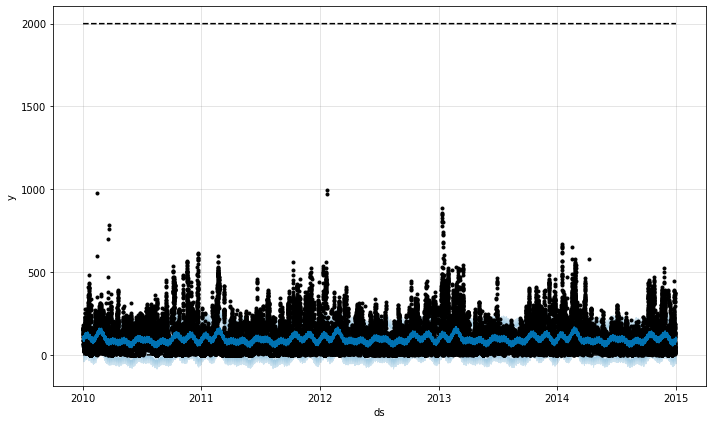

In [ ]:
fcst = m.predict(future)
fig = m.plot(fcst)

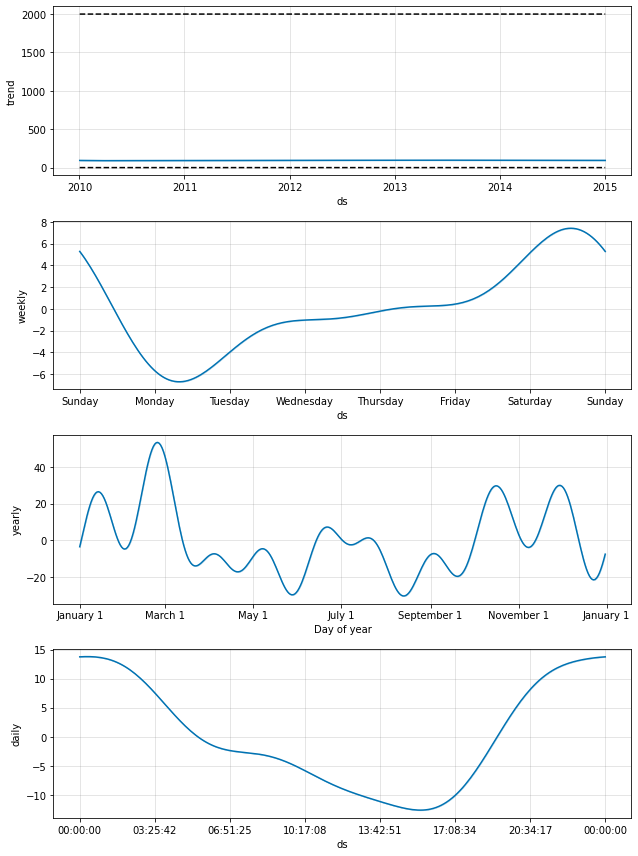

In [ ]:
fig = m.plot_components(fcst)

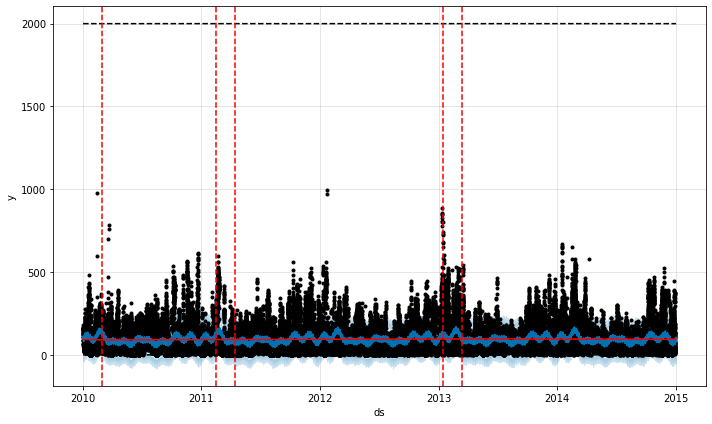

In [ ]:
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

Так себе прогноз

(0.0, 500.0)

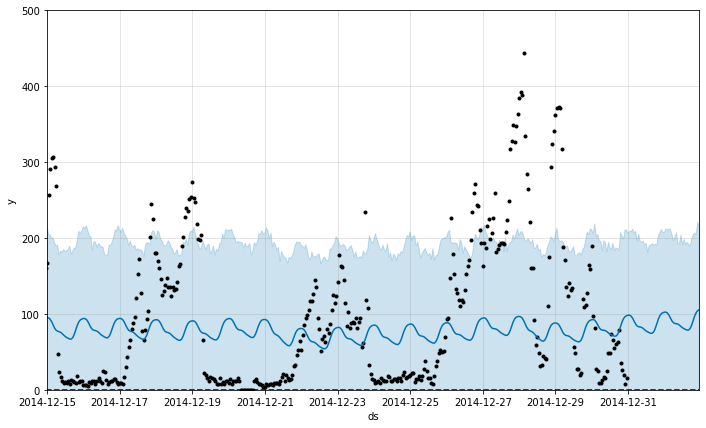

In [ ]:
fig = m.plot(fcst)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2014-12-15 00:00:00', '2015-01-01 23:00:00'])) 
ax.set_ylim([0, 500]) 

In [ ]:
df_cv = cross_validation(m, initial='730 days', period='30 day', horizon = '1 day')


INFO:fbprophet:Making 37 forecasts with cutoffs between 2012-01-14 23:00:00 and 2014-12-29 23:00:00


In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,0 days 03:00:00,8885.451666,94.262674,75.046942,0.768060,0.860565
1,0 days 04:00:00,8327.479403,91.255024,73.521012,0.864000,0.876229
2,0 days 05:00:00,7357.451614,85.775589,70.917869,0.882993,0.887592
3,0 days 06:00:00,6695.130140,81.823775,68.578233,0.968610,0.891892
4,0 days 07:00:00,6334.223900,79.587838,66.711739,1.006402,0.914619


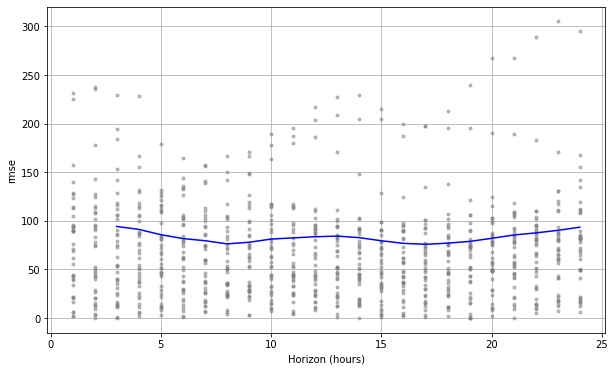

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,0 days 03:00:00,8885.451666,94.262674,75.046942,0.768060,0.860565
1,0 days 04:00:00,8327.479403,91.255024,73.521012,0.864000,0.876229
2,0 days 05:00:00,7357.451614,85.775589,70.917869,0.882993,0.887592
3,0 days 06:00:00,6695.130140,81.823775,68.578233,0.968610,0.891892
4,0 days 07:00:00,6334.223900,79.587838,66.711739,1.006402,0.914619
5,0 days 08:00:00,5828.307756,76.343354,63.635036,0.756794,0.948710
6,0 days 09:00:00,6081.961075,77.986929,65.023514,0.640818,0.934582
7,0 days 10:00:00,6602.221624,81.254056,67.624574,0.795754,0.893428
8,0 days 11:00:00,6808.381895,82.512920,67.968327,0.841500,0.869165
9,0 days 12:00:00,6999.830942,83.664992,68.043682,0.773280,0.887592


In [ ]:
print(f'RMSE on CV for fbprophet, average for 24 hours forward = {np.mean(df_p.rmse):.5f}')

RMSE on VC for fbprophet, average for 24 hours forward = 83.11816


In [ ]:
fin_pred = fcst.loc[(fcst['ds'] >= pd.to_datetime('2014-12-31 00:00:00')) & (fcst['ds'] < pd.to_datetime('2015-01-01 00:00:00'))][["ds", "yhat"]]
fin_pred.to_csv('fbpredict.csv', index=False)
fin_pred

,ds,yhat
43776,2014-12-31 00:00:00,98.316424
43777,2014-12-31 01:00:00,98.303420
43778,2014-12-31 02:00:00,97.073278
43779,2014-12-31 03:00:00,94.222766
43780,2014-12-31 04:00:00,90.264109
43781,2014-12-31 05:00:00,86.488191
43782,2014-12-31 06:00:00,84.047721
43783,2014-12-31 07:00:00,83.103258
43784,2014-12-31 08:00:00,82.815311
43785,2014-12-31 09:00:00,82.153588


In [ ]:
with open('serialized_model_fbpr.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model